In [1]:
import pulse_simulator as ps
import functools
import qiskit_dynamics as qk_d
import qiskit.providers.fake_provider as qk_fp
import numpy as np
import csv
import qiskit
import matplotlib.pyplot as plt

from qiskit.quantum_info import Operator, process_fidelity

/Users/epelaezc/Desktop/Research/pulse-simulator/.venv/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
import sys
sys.path.append("../")
from pulse_simulator.simulator import Simulator
import pulse_simulator as ps

In [3]:
backend = qk_fp.FakeManila()
units = 1e9
ns = units
dt = backend.configuration().dt * ns

In [4]:
registers = [i for i in range(1)]
config_vars = ps.backend_simulation_vars(backend, rabi=False, units=units)

H_rx = functools.partial(
    ps.rx_model,
    registers=registers,
    backend=backend,
    variables=config_vars,
    rotating_frame=False,
)

Hs_control = []
Hs_channels = []
for qubit in registers:
    Hj_drift, Hjs_control, Hjs_channel = H_rx(qubit)
    Hs_control += Hjs_control
    Hs_channels += Hjs_channel

In [5]:
good_pulses = "../pico-pulses/saved-pulses-2023-12-13/a_single_qubit_gateset_R1e-6.csv"
default_pulses = "../pico-pulses/saved-pulses-2023-12-13/a_single_qubit_gateset_default.csv"

In [6]:
def get_simulated_fidelity(sim, qc, file_name):
    gates = []
    with open(file_name) as file:
        reader = csv.reader(file)
        for row in reader:
            gates.append(np.array([float(x) for x in row]))

    expected_angles = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]
    for i in range(len(gates)):
        normalization = np.trapz(gates[i], dx=dt) / expected_angles[i]
        gates[i] = gates[i] / normalization

    for pulse, name in zip(gates, ["x_blue", "x_red", "sx_blue", "sx_red"]):
        pulse = qiskit.pulse.Waveform(pulse, limit_amplitude=False)
        sim.set_pulse(name, pulse)

    expected = Operator(qc)
    out = sim.simulate_circuit(qc)
    return process_fidelity(out, expected)

In [7]:
qc = qiskit.QuantumCircuit(2)
qc.x(0)
qc.x(1)

In [9]:
default_fidelitites = []
good_fidelities = []
strength_array = np.arange(0, 0.5, 0.01)

for strength in strength_array:
    # testing ζ Z + u(t) X
    Z_op = qiskit.quantum_info.Operator([[1, 0], [0, -1]])

    solver = qk_d.Solver(
        # static_hamiltonian=Z_op * strength,
        static_hamiltonian=np.kron(Z_op, Z_op) * strength,
        hamiltonian_operators=Hs_control,
        static_dissipators=None,
        rotating_frame=None,
        rwa_cutoff_freq=None,
        hamiltonian_channels=Hs_channels,
        channel_carrier_freqs={ch: 0.0 for ch in Hs_channels},
        dt=dt,
    )

    sim = ps.simulator.Simulator(
        basis_gates=["rz", "sx", "x", "cx"], solver=solver, backend=backend
    )

    default_fidelitites.append(get_simulated_fidelity(sim, qc, default_pulses))
    good_fidelities.append(get_simulated_fidelity(sim, qc, good_pulses))

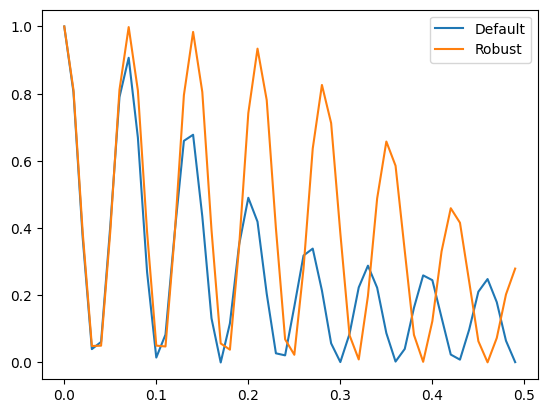

In [10]:
plt.plot(strength_array, default_fidelitites, label="Default")
plt.plot(strength_array, good_fidelities, label="Robust")
# plt.yscale("log")
plt.legend();

### Qutip

In [8]:
import qutip

In [138]:
I = np.array([[1, 0], 
              [0, 1]], dtype="complex128")
Z = np.array([[1, 0], 
              [0, -1]], dtype="complex128")
X = np.array([[0, 1], 
              [1, 0]], dtype="complex128")

H_t_ind = qutip.Qobj(Hj_drift.data)
# H_t_ind += 0.001 * qutip.Qobj(Z)

In [139]:
# times = np.linspace(0.0, np.pi, 50)
times = np.linspace(0.0, 10.0, 50)

In [140]:
gates = []
with open(good_pulses) as file:
    reader = csv.reader(file)
    for row in reader:
        gates.append(np.array([float(x) for x in row]))

expected_angles = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]
for i in range(len(gates)):
    normalization = np.trapz(gates[i], dx=dt) / expected_angles[i]
    gates[i] = gates[i] / normalization

x_blue = gates[0]
x_red = gates[1]

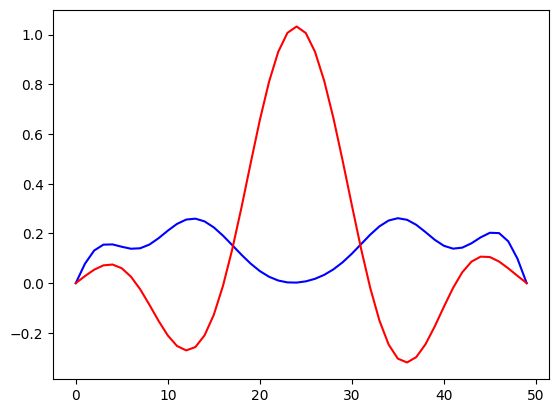

In [141]:
plt.plot(x_blue, color="blue")
plt.plot(x_red, color="red");

In [142]:
H_0_control = qutip.Qobj(Hs_control[0].data)
H = [H_t_ind, [H_0_control, x_red]]
psi0 = qutip.Qobj(I)

result = qutip.sesolve(H=H, psi0=psi0, tlist=times)

In [143]:
result.states[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 4.50719481e-01+8.92665633e-01j  1.52956740e-06+1.30818435e-04j]
 [-1.52956740e-06+1.30818435e-04j  4.50719481e-01-8.92665633e-01j]]